In [1]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_palette("RdBu")
import ipywidgets as widgets  # interactive display

my_layout = widgets.Layout()
import warnings

warnings.filterwarnings("ignore")

# Setup

## Parameters

In [2]:
# Defining parameters

# typical neuron parameters#
C_m = 200  # membrane capacitance [pF]
g_L = 10  # leak conductance [nS]
E_L = -75  # leak reversal potential [mV]
V_th = -50  # threshold current
V_reset = -65  # Post-spike reset potential [mV]
tau_m = 24  # membrane time constant [ms]
V_init = -65  # initial potential [mV]
t_ref = 2  # absolute refractory time (ms)
V_lb = -80  # lower boundary

# typical Poisson input parameters#
tau_p = 5  # Poisson time constant [ms]
j_p = 150  # Poisson weight
N_p = 300  # number of Poisson neurons
ratio_p = 5 / 1000  # noise amplitute [Hz]

# typical excitatory and inhibitory synaptic transmission parameters
V_e = 0  # Excitatory reversal potential [mV]
V_i = -85  # Inhibitory reversal potential [mV]
N_e = 340  # nr of excitatory neurons
N_i = 60  # nr of inhibitory neurons
tau_e = 8  # excitatory synaptic conductance time constant [ms]
tau_i = 4  # inhibitory synaptic conductance time constant [ms]

# Connection probabilities
p_ee = 0.01  # connection probability of exc to exc cell
p_ei = 0.15  # connection probability of inh to exc cell
p_ie = 0.15  # connection probability of exc to inh cell
p_ii = 0.1  # connection probability of inh to inh cell
p_ep = 0.1  # connection probability of Poisson to exc cell
p_ip = 0.1  # connection probability of Poisson to inh cell

# Synaptic weights
j_ee = 350  # synaptic weight from exc to exc cell
j_ei = -2100  # synaptic weight from inh to exc cell
j_ie = 2000  # synaptic weight from exc to inh cell
j_ii = -3500  # synaptic weight from inh to inh cell
j_ep = 2250  # synaptic weight from Poisson to exc cell
j_ip = 2000  # synaptic weight from Poisson to inh cell

# Conductances
gE_bar = 2.4  # excitatory conductance [nS]
gI_bar = 2.4  # inhibitory conductance [nS]

# Simulation parameters
T = 1000  # Total duration of simulation [ms]
dt = 0.1  # Simulation time step [ms]

# Time vector
time = np.arange(0, T, dt)  # Vector of discretized time points [ms]

## Plotting functions

In [3]:
# Plot membrane potential
def plot_V_m(V_neuron, spike_times, title=""):
    """
    Plot membrane potential of a single neuron

    Args:
    V_neuron    : voltage of a single neuron
    spike_times : spike train
    title       : the title of plot

    Returns:
    Figure of the membrane potential trajetory for a single neuron
    """

    plt.plot(time, V_neuron, "b")
    plt.axhline(V_th, 0, 1, color="k", ls="--")
    plt.plot(spike_times, np.max(V_neuron) + 0 * spike_times, "ro")
    plt.xlabel("Time (ms)")
    plt.ylabel("Membrane potential (mV)")
    plt.legend(
        ["Membrane\npotential", r"Threshold V$_{\mathrm{th}}$"], loc=[1.05, 0.75]
    )
    plt.title(title)
    plt.ylim([-75, 0])
    plt.show()


# Plot the raster of spike train
def plot_raster(spikes_array, title=""):
    """
    Makes raster plot with spike trains

    Args:
      spikes_array : 2d array of spike trains
                   and index of spiking neuron
      title        : title of a plot

    Returns:
      Raster plot of the Poisson spike train
    """

    plt.figure()
    plt.plot(spikes_array[0], spikes_array[1], "k.")
    plt.ylabel("Index of spiking neuron")
    plt.xlabel("Time (ms)")
    plt.title(title)
    plt.show()


# plot input-output function
def plot_IO_curve(spike_frequency_df, title=""):
    """
    Makes function showing the relationship between
    injected current and frequency of neuronal spikes

    Args:
      spike_frequency_df : DataFrame with columns of injected
                           current and spiking frequency
      title              : title of a plot

    Returns:
      I/O function plot
    """
    figure = sns.relplot(
        x="injected_current",
        y="spiking_frequency",
        data=spike_frequency_df,
        kind="line",
        markers=True,
        dashes=False,
    )
    figure.set(xlabel="Injected current (pA)", ylabel="Spiking frequency (Hz)")
    figure.fig.suptitle(title, y=1.03)
    plt.show()


# ploting histograms of CV
def plot_hist(isi, bin, title=""):
    """
    Args:
      isi : vector with inter-spike intervals
      cv  : coefficient of variation for isi


    Returns:
      figure with histograms
    """
    plt.figure()
    plt.hist(isi, bins=bin, color="b")
    plt.xlabel("Inter-spike intervals (ms)")
    plt.ylabel("count")
    plt.title(title)

## Model functions

In [4]:
# Generate Poisson spike trains


def generate_poisson_spikes(myseed=False, verbose=False):
    """
    Generates poisson spike trains

    Args:
      myseed                    : random seed. int or boolean
      verbose                   : if True, printing additional information in cell
      parameters                : initialized parameters

    Returns:
      p_spikes_array            : array with two rows - p_spikes_array[0,:] -
                                a vector of spike times and p_spikes_array[1,:]
                                is a vector of which neuron spiked
      I_p                       : Input current [pA] (here: generated by Poisson distribution)
      I_p_bar                   : Theoretical input current [pA]
      p_spikes_count            : Total number of Poisson spikes
    """

    # set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # The max number of Poisson spikes
    # ratio_p*N_p*T
    p_spikes_count = np.random.poisson(ratio_p * N_p * T)
    p_spikes_array = np.zeros((2, p_spikes_count))

    # Spike times and indices are uniformly distributed
    p_spikes_array[0, :] = np.random.rand(p_spikes_count) * T
    p_spikes_array[1, :] = np.random.randint(0, N_p, size=p_spikes_count)

    # Sort spike times
    sort = np.argsort(p_spikes_array[0, :])
    p_spikes_array = p_spikes_array[:, sort]

    # Initialize Input current
    I_p = np.zeros_like(time)

    # Implement the ODE of the Poisson model
    p_spike_index = 0
    for i in range(1, len(time)):
        I_p[i] = I_p[i - 1] - dt * I_p[i - 1] / tau_p
        while (
            p_spike_index < p_spikes_count
            and p_spikes_array[0, p_spike_index] <= i * dt
        ):
            I_p[i] += j_p / tau_p
            p_spike_index += 1

    # Calculate theoretical stationary mean value
    # of I_p, i.e., E[I_p]
    I_p_bar = N_p * j_p * ratio_p

    # Printing additional information in cells (optional)
    if verbose == True:
        print("Theoretical mean of Poisson input current:", I_p_bar)
        print("Empirical mean of Poisson input current:", np.mean(I_p))

    return p_spikes_array, I_p, I_p_bar, p_spikes_count


# run single neuron model
def run_EIF(I_pre, I_int=False, verbose=False):
    """
    Simulate a single neuron modeled as Exponential Integrate and Fire (EIF) neuron dynamics with external input current

    Args:
      I_pre             : presynaptic input current [pA] (value or an array)
      I_int             : true when it is constant current, not an array
      verbose           : printing additional information in cell

    Returns:
      spike_times       : spike times [ms] (1D array)
      V_neuron          : mebrane potential [mV] (1D array)
      spiking_frequency : frequency of neuronal spikes in Hz (int)
    """
    # Initialize membrane potential and external current
    V_neuron = np.zeros(len(time))
    V_neuron[0] = V_init

    # Depending whether neuron receives injected current (I_inj) or poisson spikes (I_p)
    if I_int == True:
        I_pre = I_pre * np.ones(len(time))

    # Initialize postsynaptic spike train vector
    spike_times = np.zeros(len(time))  # record spike times
    spike_index = 0

    # Simulate EIF dynamics
    for i in range(1, len(time)):
        # Update the membane potential
        V_neuron[i] = (
            V_neuron[i - 1]
            + dt
            * (
                I_pre[i - 1] / g_L
                + (E_L - V_neuron[i - 1])
                + t_ref * np.exp((V_neuron[i - 1] - V_th) / t_ref)
            )
            / tau_m
        )
        V_neuron[i] = np.maximum(V_neuron[i], V_lb)

        # if there is a spike
        if V_neuron[i] >= V_th:
            V_neuron[i] = V_reset
            V_neuron[i - 1] = V_th + 40  # This just makes plots look nicer
            spike_times[spike_index] = i * dt
            spike_index += 1

    # Store only spike times
    spike_times = spike_times[:spike_index]

    # Calculating firing rate in Hz
    rate = (spike_index) / T
    spiking_frequency = 1000 * rate  # in Hz

    # Printing additional information in cells (optional)
    if verbose == True:
        print("Number of spikes:", spike_index)
        print("Postsynaptic rate =", spiking_frequency, "Hz")

    return V_neuron, spike_times, spiking_frequency


# Input-Output function
def run_IO(I_min=0, I_max=500, step=10):
    """
    run simulation with increasing current steps and measure frequency of EIF neuron

    Args:
      I_min             : minimal current step applied (pA)
      I_max             : maximal current step applied (pA)
      step              : difference between current steps (pA)

    Returns:
      spiking_df        : DataFrame with the spiking frequency and current steps
    """
    # Initializing input current and vectors
    I_inj = np.arange(I_min, I_max, step)
    spiking_array = np.zeros(((len(I_inj), 2)))

    # Stimulate neurons with external current of increasing amplitudes and store frequency and current amplitude
    for index, inj in enumerate(I_inj):
        V_neuron, spike_times, spiking_frequency = run_EIF(
            I_pre=inj, I_int=True, verbose=False
        )
        spiking_array[index, 0] = inj
        spiking_array[index, 1] = spiking_frequency

    # change array to pandas DataFrame
    spiking_df = pd.DataFrame(spiking_array, index=None)
    spiking_df.columns = ["injected_current", "spiking_frequency"]

    return spiking_df


def run_ff_network(verbose=False):
    """
    Simulate a feedforward neuronal network consisting of EIF neuron

    Args:
      parameters        : initialized parameters
      verbose           : if True, printing additional information in cell

    Returns:
      V_e_array         : array of excitatory population with
                          membrane potential of each neuron in time
      spikes_array      : array where [0,:] is spiking times,
                         and [1,:] is the index of spiking neuron
      spiking_frequency : mean frequency of spiking neuronal population [Hz] (int)
    """

    # Connectivity matrix from presynaptic population
    # to postsynaptic population
    J_p = j_p * np.random.binomial(1, p_ep, (N_e, N_p))

    # Simulate Poisson spikes
    p_spikes_array, I_p, I_p_bar, p_spikes_count = generate_poisson_spikes(myseed=2022)

    # Initialize neuronal potentials and currents
    I_ee = np.zeros(N_e)
    I_ep = np.zeros(N_e)
    V_e = np.random.rand(N_e) * (V_th - E_L) + E_L
    V_e_array = np.zeros((N_e, len(time)))
    V_e_array[:, 0] = V_init

    # Initialize postsynaptic spike train
    spikes_array = np.zeros((2, len(time) - 1))
    spike_index = 0
    p_spike_index = 0

    # Run simulation
    for i in range(1, len(time)):

        # Update synaptic current
        I_ee = I_ee - dt * I_ee / tau_e
        I_ep = I_ep - dt * I_ep / tau_p

        while p_spikes_array[0, p_spike_index] <= i * dt:
            I_ep += J_p[:, (int)(p_spikes_array[1, p_spike_index])] / tau_p
            p_spike_index += 1

        # Update membrane potential
        V_e = (
            V_e
            + dt * (I_ep + (E_L - V_e) + t_ref * np.exp((V_e - V_th) / t_ref)) / tau_m
        )
        V_e = np.maximum(V_e, V_lb)  # lower boundry
        V_e_array[:, i] = V_e

        # Find which excitatory neurons spiked
        spiking_neuron = np.nonzero(V_e >= V_th)[0]
        if spiking_neuron.any():
            # Store spike times and neuron indices
            spikes_array[0, spike_index : spike_index + len(spiking_neuron)] = dt * i
            spikes_array[
                1, spike_index : spike_index + len(spiking_neuron)
            ] = spiking_neuron

            # Reset membrane potential
            V_e[spiking_neuron] = V_reset

            # Update cumulative number of spikes (excitatory cells)
            spike_index = spike_index + len(spiking_neuron)

            # Update potential array for a spiking neuron
            V_e_array[spiking_neuron, i] = V_th + 40  # This just makes plots look nicer

    # Save only columns with spikes
    spikes_array = spikes_array[:, :spike_index]

    # Mean rate
    spiking_frequency = spike_index / (N_e * T) * 1000

    # Printing additional information in cells (optional)
    if verbose == True:
        print("Mean postsynaptic rate=", spiking_frequency, "Hz")
        print("Sample mean synaptic input=", np.mean(I_p), "mV")

    return V_e_array, spikes_array, spiking_frequency


def run_recurrent_network(j_ee, j_ei, j_ie, j_ii, j_ep, j_ip, verbose=False):
    """
    Simulate a recurrent neuronal network consisting of EIF neuron

      Args:
        parameters        : initialized parameters
        verbose           : if True, printing additional information in cell



    Returns:
      e_spikes_array      : array of excitatory population
                          where [0,:] is spiking times,
                          and [1,:] is the index of spiking neuron
      i_spikes_array      : array of inhibitory population
                          where [0,:] is spiking times,
                          and [1,:] is the index of spiking neuron
      V_e_array           : array of excitatory population with
                            membrane potential of each neuron in time
      V_i_array           : array of inhibitory population with
                            membrane potential of each neuron in time
    """

    # Number of neurons
    N = N_e + N_i

    # Synaptic weights
    j_ee = j_ee / np.sqrt(N)
    j_ei = j_ei / np.sqrt(N)
    j_ie = j_ie / np.sqrt(N)
    j_ii = j_ii / np.sqrt(N)
    j_ep = j_ep / np.sqrt(N)
    j_ip = j_ip / np.sqrt(N)

    # Connectivity matrix from presynaptic population
    # to postsynaptic population
    J_ee = j_ee * np.random.binomial(1, p_ee, (N_e, N_e))
    J_ei = j_ei * np.random.binomial(1, p_ei, (N_e, N_i))
    J_ie = j_ie * np.random.binomial(1, p_ie, (N_i, N_e))
    J_ii = j_ii * np.random.binomial(1, p_ii, (N_i, N_i))
    J_ep = j_ep * np.random.binomial(1, p_ep, (N_e, N_p))
    J_ip = j_ip * np.random.binomial(1, p_ip, (N_i, N_p))

    # Simulate Poisson input
    p_spikes_array, I_p, I_p_bar, p_spikes_count = generate_poisson_spikes(myseed=2022)

    # Initialize potentials and currents
    I_ee = np.zeros(N_e)
    I_ei = np.zeros(N_e)
    I_ie = np.zeros(N_i)
    I_ii = np.zeros(N_i)
    I_ep = np.zeros(N_e)
    I_ip = np.zeros(N_i)
    V_e = np.random.rand(N_e) * (V_th - E_L) + E_L
    V_i = np.random.rand(N_i) * (V_th - E_L) + E_L
    V_e_array = np.zeros((N_e, len(time)))
    V_i_array = np.zeros((N_i, len(time)))
    V_e_array[:, 0] = V_init
    V_i_array[:, 0] = V_init

    # Initialize postsynaptic spike array
    e_spikes_array = np.zeros((2, int(N_e * T / dt)))
    i_spikes_array = -np.zeros((2, int(N_i * T / dt)))
    e_spike_index = 0
    i_spike_index = 0
    p_spike_index = 0
    # startsim = tm()

    for i in range(1, len(time)):

        # Update synaptic current
        I_ee = I_ee - dt * I_ee / tau_e
        I_ei = I_ei - dt * I_ei / tau_i
        I_ie = I_ie - dt * I_ie / tau_e
        I_ii = I_ii - dt * I_ii / tau_i
        I_ep = I_ep - dt * I_ep / tau_p
        I_ip = I_ip - dt * I_ip / tau_p

        while p_spikes_array[0, p_spike_index] <= i * dt:
            I_ep += J_ep[:, (int)(p_spikes_array[1, p_spike_index])] / tau_p
            I_ip += J_ip[:, (int)(p_spikes_array[1, p_spike_index])] / tau_p
            p_spike_index += 1

        # Update membrane potential
        V_e = (
            V_e
            + dt
            * (I_ee + I_ei + I_ep + (E_L - V_e) + t_ref * np.exp((V_e - V_th) / t_ref))
            / tau_m
        )
        V_e = np.maximum(V_e, V_lb)
        V_e_array[:, i] = V_e
        V_i = (
            V_i
            + dt
            * (I_ie + I_ii + I_ip + (E_L - V_i) + t_ref * np.exp((V_i - V_th) / t_ref))
            / tau_m
        )
        V_i = np.maximum(V_i, V_lb)
        V_i_array[:, i] = V_i

        # Find which e neurons spiked
        e_spiking_neuron = np.nonzero(V_e >= V_th)[0]
        if e_spiking_neuron.any():
            # Store spike times and neuron indices
            e_spikes_array[0, e_spike_index : e_spike_index + len(e_spiking_neuron)] = (
                dt * i
            )
            e_spikes_array[
                1, e_spike_index : e_spike_index + len(e_spiking_neuron)
            ] = e_spiking_neuron

            # Reset membrane potential
            V_e[e_spiking_neuron] = V_reset

            # Propagate spikes
            I_ee = I_ee + J_ee[:, e_spiking_neuron].sum(axis=1) / tau_e
            I_ie = I_ie + J_ie[:, e_spiking_neuron].sum(axis=1) / tau_e

            # Update cumulative number of spikes (excitatory cells)
            e_spike_index = e_spike_index + len(e_spiking_neuron)

            # Update potential array for a spiking neuron
            V_e_array[e_spiking_neuron, i] = (
                V_th + 40
            )  # This just makes plots look nicer

        # Find which i neurons spiked
        i_spiking_neuron = np.nonzero(V_i >= V_th)[0]
        if i_spiking_neuron.any():
            # Store spike times and neuron indices
            i_spikes_array[0, i_spike_index : i_spike_index + len(i_spiking_neuron)] = (
                dt * i
            )
            i_spikes_array[
                1, i_spike_index : i_spike_index + len(i_spiking_neuron)
            ] = i_spiking_neuron

            # Reset membrane potential
            V_i[i_spiking_neuron] = V_reset

            # Propagate spikes
            I_ei = I_ei + J_ei[:, i_spiking_neuron].sum(axis=1) / tau_i
            I_ii = I_ii + J_ii[:, i_spiking_neuron].sum(axis=1) / tau_i

            # Update cumulative number of spikes (interneurons)
            i_spike_index = i_spike_index + len(i_spiking_neuron)

            # Update potential array for a spiking neuron
            V_i_array[i_spiking_neuron, i] = (
                V_th + 40
            )  # This just makes plots look nicer

    # Store only spikes
    e_spikes_array = e_spikes_array[:, :e_spike_index]
    i_spikes_array = i_spikes_array[:, :i_spike_index]

    # Mean rates in Hz
    e_mean_spiking_rate = e_spike_index / (N_e * T) * 1000
    i_mean_spiking_rate = i_spike_index / (N_i * T) * 1000

    # Printing additional information in cells (optional)
    if verbose == True:
        print("Mean rate of excitatory neurons=", e_mean_spiking_rate, "Hz")
        print("Mean rate of inhibitory neurons=", i_mean_spiking_rate, "Hz")

    return e_spikes_array, i_spikes_array, V_e_array, V_i_array


def calculate_cv(spike_times):
    """
    Calculates the inter-spike intervals (isi) and
    the coefficient of variation (cv) for a given spike_train

    Args:
      spike_times : (n, ) vector with the spike times (ndarray)

    Returns:
      isi         : (n-1,) vector with the inter-spike intervals (ms)
      cv          : coefficient of variation of isi (float)

    """

    if len(spike_times) >= 2:
        # Compute isi
        isi = np.diff(spike_times)
        # Compute cv
        cv = isi.std() / isi.mean()
    else:
        print("Not enough spikes to calculate coefficient of variance!")
        isi = np.nan
        cv = np.nan

    return isi, cv

# Modeling a postsynaptic neuron and simulating it with an inject external (i.e., "injected") current

Here I model the membrane potential of a postsynaptic neuron using the exponential integrate-and-fire (EIF) model, which obeys the ODE
$$
\tau_m \frac{dV}{dt}=-(V_{neuron}-E_L)+t_{ref} e^{(V_{neuron}-V_{th})/t_{ref}}+I_p
$$
with the added condition
$$
V_{neuron}(t)\ge V_{th}\Rightarrow V_{neuron}(t)\gets V_{reset},\textrm{record a spike}
$$

Number of spikes: 31
Postsynaptic rate = 31.0 Hz


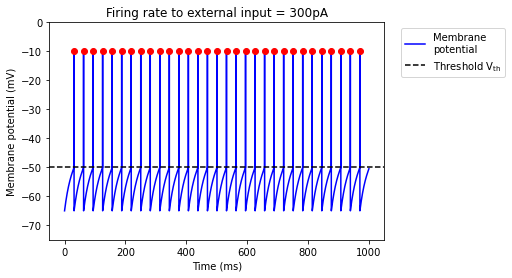

In [21]:
V_neuron, spike_times, _ = run_EIF(I_pre=300, I_int=True, verbose=True)
plot_V_m(V_neuron, spike_times, title="Firing rate to external input = 300pA")

## Explore amplitude of the input current
We can see above that when I inject 300pA external current, this particular neuron with properties described in parameteres section, produces 31 action potentials (spikes). Note that these are just cosmetic spikes only for illustration purposes. In this type of model, we only need to keep track of times when the neuron hit the threshold so the postsynaptic neurons can be informed of the spike. The properties of these spikes are ignored.

Nevertheless, when we change the amount of injected current, the response of this neurons changes. It can be visualize below.

In [6]:
# @markdown To enable the widget, this cell should be executed!

# Widget with injected current
my_layout.width = "450px"


@widgets.interact(
    injected_current=widgets.FloatSlider(50, min=0, max=500, step=20, layout=my_layout)
)
def different_I_inj(injected_current=200):
    V_neuron, spike_times, _ = run_EIF(
        I_pre=injected_current, I_int=True, verbose=False
    )
    plot_V_m(V_neuron, spike_times)
    plt.show()

interactive(children=(FloatSlider(value=50.0, description='injected_current', layout=Layout(width='450px'), ma…

## Input-output function
In electrophysiological studies, the number of spikes which neurons produce in a given time to increasing current steps is called "Input-Output Fuction". For this particular neuron, it looks like it:

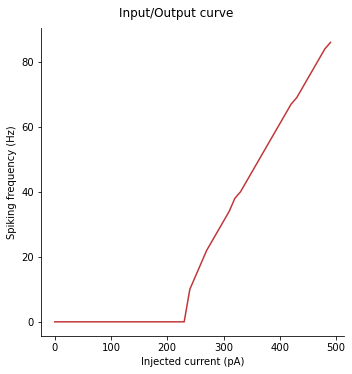

In [7]:
spike_frequency_df = run_IO()
plot_IO_curve(spike_frequency_df, title="Input/Output curve")

# Simulate neuron with synaptic current modeled as Poisson process

In brain networks, a neuron receives input current not as a fixed injected current but as a sum of synaptic contacts that other neurons made on it. It can be modeled as Poisson process. 

## Poisson process
`poisson_spikes_matrix ` is a family of $N_p$ Poisson processes modeling the spike times of $N_p$ neurons. It is stored as a matrix with two rows. The first row, `poisson_spikes_matrix[0,:]`, is a vector of spike times (random numbers in $[0,T]$) and `poisson_spikes_matrix[1,:]` is a vector of associated neuron indices (integers from  $0$ to  $N_p-1$). 

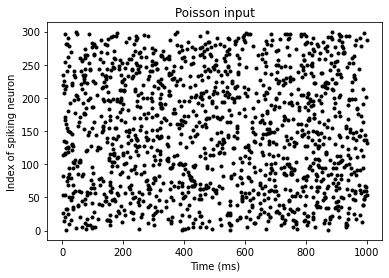

In [8]:
# Simulate Poisson spikes
p_spikes_array, I_p, I_p_bar, p_spikes_count = generate_poisson_spikes(myseed=2022)
# Plot Poisson spikes
plot_raster(p_spikes_array, title="Poisson input")

## Equasions
We assume that our neuron receives excitatory synaptic input from all  $N_p$ neurons (each neuron is represented as a row of a raster plot showed above) modeled by the Poisson processes above. These neurons produce spikes (dots above) in specific time during our simulation, which evokes an expontentially decaying current pulse so the current is given by 
$$
I_p(t)=\sum_{k=1}^{N_p}j_p\sum_i \alpha_x(t-t_{i,k})
$$
where $t_{i,k}$ is the $i$th spike time of neuron $k=1,\ldots,N_p$,
$$
\alpha_p(t)=e^{-t/\tau_p}H(t),
$$
and $H(t)$ is the Heavisde step function. The current can equivalently be modeled by the ODE
$$
\tau_p\frac{dI_p}{dt}=-I_p
$$
with the added rule
$$
I_p(t_{i,k})\gets I_p(t_{i,k})+j_p/\tau_p
$$

**Theory:** The mean synaptic current is  given by 
$$
\overline{I}_p=N_p j_p r_p
$$

Now model the membrane potential of a postsynaptic neuron using the exponential integrate-and-fire (EIF) model, which obeys the ODE
$$
\tau_m \frac{dV_{neuron}}{dt}=-(V_{neuron}-E_L)+t_{ref} e^{(V_{neuron}-V_{th})/t_{ref}}+I_p
$$
with the added condition
$$
V_{neuron}(t)\ge V_{th}\Rightarrow V_{neuron}(t)\gets V_{reset},\textrm{ record a spike}
$$

Number of spikes: 5
Postsynaptic rate = 5.0 Hz


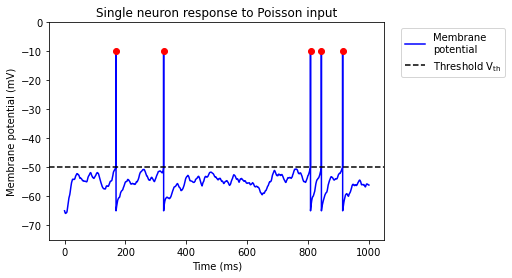

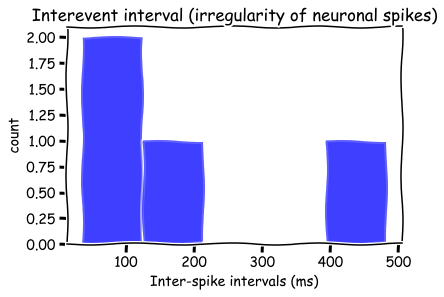

In [25]:
# Response of postsynaptic neuron to Poisson spikes
V_neuron, spikes_array, _ = run_EIF(I_pre=I_p, verbose=True)
plot_V_m(V_neuron, spikes_array, title="Single neuron response to Poisson input")
# Calculate the irregularity of spikes
isi, cv = calculate_cv(spikes_array)
# Visualize with xkcd styling
with plt.xkcd():
    plot_hist(isi, bin=5, title="Interevent interval (irregularity of neuronal spikes)")

# Modeling a single-layer feedforward neuronal network

Ok, but what if we are not interested in one postsynaptic neuron, but in whole neuronal population? Then the same Poisson presynaptic layer could make synapses onto $N_e$ postsynaptic neurons (assume that neurons are only excitatory for now). 

Each presynaptic neuron connects to each postsynaptic neuron with probability $p_{ep}$ (from poisson neuron to excitatory neuron). 

The model obeys
$$
\tau_p\frac{d\vec I_p}{dt}=-\vec I_p
$$
$$
\tau_m \frac{d\vec V}{dt}=-(\vec V-E_L)+t_{ref} e^{(\vec V-V_{th})/t_{ref}}+\vec I_p
$$
with the added rules
$$
\vec I_p(t_{i,k})\gets \vec I_p(t_{i,k})+J_p(:,k)
$$
and
$$
V_j(t)\ge V_{th}\Rightarrow V_j(t)\gets V_{reset},\textrm{ record a spike in neuron }j
$$

Thus, the raster plot of our excitatory population to previous Poisson input looks like:

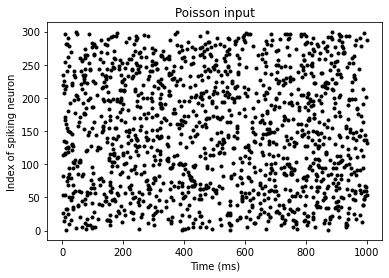

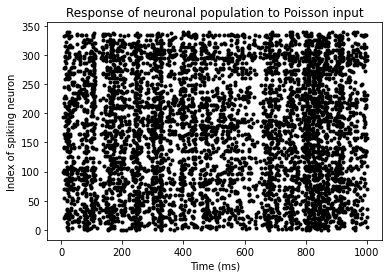

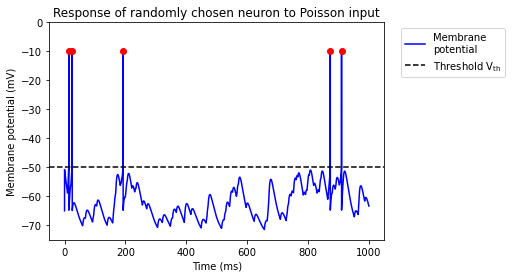

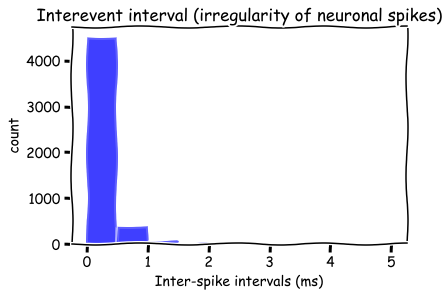

In [30]:
# The same Poisson input
plot_raster(p_spikes_array, title="Poisson input")
# Run feedforward network simulation
V_e_array, spikes_array, spiking_frequency = run_ff_network()
# Neuronal responses to Poisson input
plot_raster(spikes_array, title="Response of neuronal population to Poisson input")
# Randomly choose one of excitatory neuron plot its membrane potential
chosen_neuron = np.random.randint(0, N_e)
plot_V_m(
    V_e_array[chosen_neuron],
    spikes_array[0, spikes_array[1, :] == chosen_neuron],
    title="Response of randomly chosen neuron to Poisson input",
)
# Calculate the irregularity
isi, cv = calculate_cv(spikes_array[0])
# Visualize with xkcd styling
with plt.xkcd():
    plot_hist(
        isi, bin=10, title="Interevent interval (irregularity of neuronal spikes)"
    )

# Modeling a recurrent network

In the brain, there are not only excitatory neurons ($N_e$) but also inhibitory ($N_i$). Neurons are also interconnected with each other and between populations with a certain level of probability. Thus, in this model, recurrent connections were added between neurons. Also both these populations receive input from an external population of Poisson processes ($N_p$). 

Connection probability from population $b=e,i,p$ to population $a=e,i$ is denoted $p_{ab}$ and the synaptic weight by $j_{ab}$. 

The synaptic current from population $b=e,i,p$ to population $a=e,i$ obeys
$$
\tau_{b}\frac{d\vec I_{ab}}{dt}=-\vec I_{ab}
$$
with the added rule
$$
\vec I_{ab}(t^b_{i,k})\gets \vec I_p(t^b_{i,k})+J_{ab}(:,k)/\tau_b
$$
where $t^b_{i,k}$ is the $i$th spike of neuron $k$ in population $b$ and $J_{ab}$ is the connection matrix from from population $b=e,i,p$ to population $a=e,i$.

The membrane potentials of neurons in population $a=e,i$ obey
$$
\tau_m \frac{d\vec V_a}{dt}=-(\vec V_a-E_L)+t_{ref} e^{(\vec V_a-V_{th})/t{ref}}+\vec I_{ae}+\vec I_{ai}+\vec I_{ap}
$$
with the added rule
$$
V_j(t)\ge V_{th}\Rightarrow V_j(t)\gets V_{re},\textrm{ record a spike in neuron }j
$$

**Theory:**
The mean input from $b$ to $a$ is given by
$$
\overline{I_{ab}}=w_{ab}r_b
$$
where
$$
w_{ab}=N_b p_{ab}j_{ab}
$$
and $r_b$ is the mean rate of neurons in population $b$. If 
$$
j_{ab}\sim 1/\sqrt N
$$ 
where $N_b\sim N$ then 
$$
\overline{I_{ab}}\sim\sqrt N.
$$
Now let 
$$
\overline{I_a}=I_{ae}+I_{ai}+I_{ap}
$$
be the mean-field total input to neurons in population $a$. 
Then we can only have 
$$
r_a,\overline{I_a}\sim\mathcal O(1) 
$$
if there is a cancellation between $I_{ae}$, $I_{ai}$, and $I_{ap}$ in the large $N$ limit. We can write 
$$
{\bf I}=\left[\begin{array}{c}\overline{I_e}\\ \overline{I_i}\end{array}\right]=W{\bf r}+W_x r_x
$$
where 
$$
W=\left[\begin{array}{cc}w_{ee} & w_{ei}\\ w_{ie} & w_{ii}\end{array}\right]
$$
$$
W_p=\left[\begin{array}{c}w_{ep}\\ w_{ip}\end{array}\right]
$$
and
$$
{\bf r}=\left[\begin{array}{c}{r_e}\\ {r_i}\end{array}\right]
$$
Cancellation requires that 
$$
W{\bf r}\approx -W_p r_p
$$
in the large $N$ limit, so 
$$
\lim_{N\to\infty}{\bf r}=-W^{-1}W_p r_p
$$


Mean rate of excitatory neurons= 1.4617647058823529 Hz
Mean rate of inhibitory neurons= 6.566666666666666 Hz


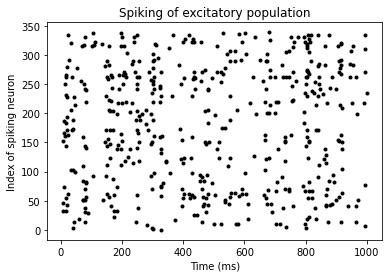

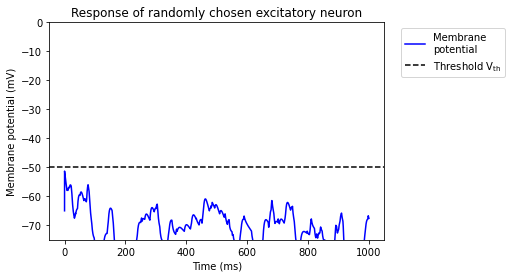

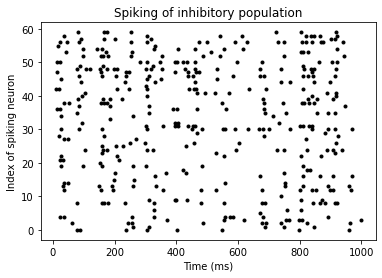

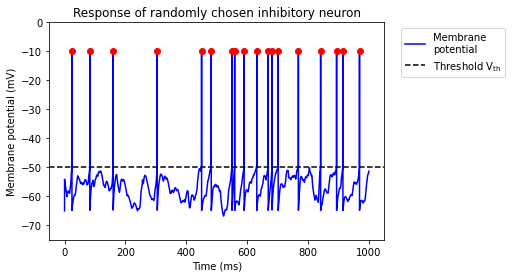

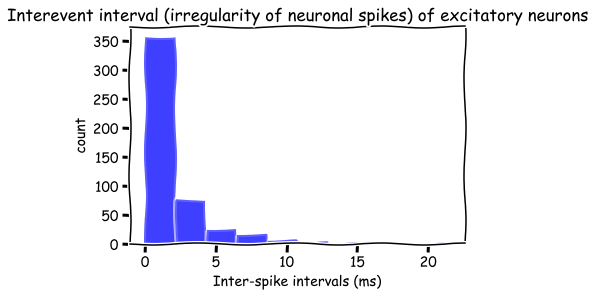

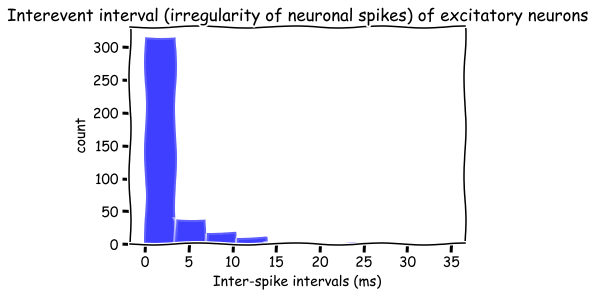

In [31]:
e_spikes_array, i_spikes_array, V_e_array, V_i_array = run_recurrent_network(
    j_ee, j_ei, j_ie, j_ii, j_ep, j_ip, verbose=True
)
# Neuronal responses from excitatory neurons
plot_raster(e_spikes_array, title="Spiking of excitatory population")
# Randomly choose one of excitatory neuron and plot its membrane potential
chosen_neuron = np.random.randint(0, N_e)
plot_V_m(
    V_e_array[chosen_neuron],
    e_spikes_array[0, e_spikes_array[1, :] == chosen_neuron],
    title="Response of randomly chosen excitatory neuron",
)
# Neuronal responses from inhibitory neurons
plot_raster(i_spikes_array, title="Spiking of inhibitory population")
# Randomly choose one of inhibitory neuron and plot its membrane potential
chosen_neuron = np.random.randint(0, N_i)
plot_V_m(
    V_i_array[chosen_neuron],
    i_spikes_array[0, i_spikes_array[1, :] == chosen_neuron],
    title="Response of randomly chosen inhibitory neuron",
)
# Calculate the irregularity
isi_e, cv_e = calculate_cv(e_spikes_array[0])
# Visualize with xkcd styling
with plt.xkcd():
    plot_hist(
        isi_e,
        bin=10,
        title="Interevent interval (irregularity of neuronal spikes) of excitatory neurons",
    )
# Calculate the irregularity
isi_i, cv_i = calculate_cv(i_spikes_array[0])
# Visualize with xkcd styling
with plt.xkcd():
    plot_hist(
        isi_i,
        bin=10,
        title="Interevent interval (irregularity of neuronal spikes) of inhibitory neurons",
    )